In [10]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os
from langchain_huggingface import HuggingFaceEmbeddings

load_dotenv

<function dotenv.main.load_dotenv(dotenv_path: Union[str, ForwardRef('os.PathLike[str]'), NoneType] = None, stream: Optional[IO[str]] = None, verbose: bool = False, override: bool = False, interpolate: bool = True, encoding: Optional[str] = 'utf-8') -> bool>

In [11]:
from langchain.tools import tool

os.environ["HUGGING_FACE_TOKEN"] = os.getenv("HUGGING_FACE_TOKEN")

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

Custom tool

In [12]:
@tool
def multiply(a:int,b:int)->int:
    """Multiply two integers and return the result."""
    return a*b

@tool
def add(a:int, b:int)->int:
    """Add two integers and return the result."""
    return a+b

@tool
def divide(a:int, b:int)->float:
    """Divide two integers and return the result."""
    return a/b

In [13]:
from langchain_community.tools import DuckDuckGoSearchRun

search = DuckDuckGoSearchRun()

search.invoke("When is Iphone 17 is coming")

"iPhone 17 release date: When is the next iPhone coming out? Here's something we do know: The new iPhone lineup is almost always announced in September—usually on a Tuesday in the second week ... All four iPhone 17 models that are coming in 2025 will have Apple's first custom-designed Wi-Fi chip with Wi-Fi 7 support. Wi-Fi 7 is already used in the iPhone 16 models, ... iPhone 17 Series: Launch It has been announced that the iPhone 17 family will come out on either September 11, 12 or 13, 2025, following the usual Apple autumn schedule. Among the phones in the lineup, you'll find the iPhone 17 Air which is more compact and both Pro models are set to receive major updates. iPhone 17 Series: Design The iPhone 17 Air is rumoured to come with an ultra-thin chassis, with early whispers suggesting a thickness of around 6mm, down from the iPhone 16 Pro's more substantial 8.25mm. This reduction in bulk isn't just for aesthetics. Apple appears to be re-engineering the internal layout to accommod

In [14]:
tools = [multiply, add, divide, search]

In [15]:
llm_model = ChatGroq(temperature=0, model="deepseek-r1-distill-llama-70b")

#check
llm_model.invoke("Hello").content

'<think>\n\n</think>\n\nHello! How can I assist you today? 😊'

In [17]:
llm_with_tools = llm_model.bind_tools(tools)

In [18]:
response = llm_with_tools.invoke("What is 2+2")

In [19]:
response.content

''

In [20]:
response.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 2},
  'id': 'smjb97ha0',
  'type': 'tool_call'}]

In [56]:
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode

In [57]:
builder = StateGraph(MessagesState)

In [58]:
SYSTEM_PROMPT = "You are a helpful assisstant tasked with using search and performing arithmetic on a set of inputs"
user_query = ["what is 2+2"]

In [59]:
def function_1(state:MessagesState):
    user_question = state['messages']
    
    input_question = [SYSTEM_PROMPT] + user_question
    
    response = llm_with_tools.invoke(input_question)
    
    return {
        "messages": [response]
    }

In [60]:
builder.add_node("LLM_decision_maker", function_1)

In [61]:
builder.add_node("tools", ToolNode(tools))

In [62]:
builder.add_edge(START, "LLM_decision_maker")

In [63]:
from langgraph.prebuilt import tools_condition #inbuilt router function

builder.add_conditional_edges("LLM_decision_maker",
                              tools_condition
                              )

In [64]:
builder.add_edge("tools", "LLM_decision_maker")

In [65]:
react_graph = builder.compile()

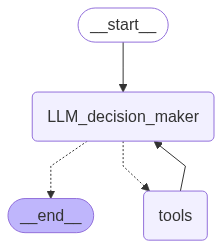

In [66]:
from IPython.display import Image, display

display(Image(react_graph.get_graph().draw_mermaid_png()))

In [67]:
message = [HumanMessage(content="What is the 2 times of MS dhoni age")]

In [70]:
response = react_graph.invoke({"messages": message})

In [ ]:
for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is the 2 times of MS dhoni age
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (a7r2cemja)
 Call ID: a7r2cemja
  Args:
    query: MS Dhoni age 2023
================================= Tool Message =================================
Name: duckduckgo_search

2023: 41: Captained Chennai Super Kings to fifth IPL victory: 2023: 41: ... At the age of 33, MS Dhoni won his last ICC Tournament as a Captain of the Indian Cricket Team. MS Dhoni played his last ... Learn about MS Dhoni's birthday, date of birth and age as of 2023. Find out how he became a cricket legend and how fans celebrate his contributions to the sport. Cricket News: MS Dhoni marked his 400th T20 match, joining an elite group of Indian cricketers. ... It marks his first full-time return to leadership since the unforgettable 2023 IPL final, where ... MS Dhoni's Age in 2023. As of t

: 